# Imports

In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Preprocessing

Only run this code once
-----


In [181]:
data = pd.read_csv('train.csv')

data = data.dropna(subset=['original'])

naive_data= data.notnull().sum()

# 성별이 NaN 처리된 데이터를 0 또는 1로 채움
# 단, 한 사람의 데이터의 경우 성별을 하나로 통일
gender = np.random.choice([0,1])
for i in data[data['1'].isnull()].iterrows():
    if i[1]['timestamp(hr)'] != 0:
        data['1'][i[0]] = gender
    else:
        data['1'][i[0]] = gender
        gender = np.random.choice([0,1])

# 나이가 NaN처리된 데이터는 나이의 평균값을 반올림하여 채움
data['2'].fillna(value= data['2'].mean().round(),inplace=True)


# 환자가 확진을 받는 시점 수 == 환자 수
patients= []
for idx, i in enumerate(data.iterrows()):
    if i[1]['timestamp(hr)'] == 0:
        patients.append(idx)

# 각 환자별로 빈값들을 Linear interpolate 밑 backfill
# 한 환자의 모든 관측정보에서 단한번도 등장하지 않았던 feature값들은 여전히 NaN
# 이 값들은 해당 데이터의 평균으로 imputation
random_weight = np.random.uniform(-2,2)
start =0
for  end in patients:
    data.iloc[start:end+1,:34] = data.iloc[start:end +1, :34].interpolate()
    start = end+1
start =0
for  i, end in enumerate(patients):
    if i%10 == 0:
        print(i)
    data.iloc[start:end+1,:34] = data.iloc[start:end +1, :34].interpolate(method='bfill')
    data.iloc[start:end+1,:34].fillna(data.iloc[start:end+1,:34].mean()+ random_weight*data.std(),inplace=True)
    start = end+1
data.to_csv('notnull_train.csv')

KeyboardInterrupt: 

If you already run the code above than start from here
-----



In [182]:
data = pd.read_csv('notnull_train.csv', index_col=0)
data.fillna(data.mean(), inplace=True)

smote
======

Before Augmentation

0: 63085 , -1: 37555, -2: 26548, -3: 48326 (-3 : 20390, -4: 16274, -5: 11662)

After using smote

0: 63085 , -1: 60000, -2: 60000, -3: 60390 (-3 : 20390, -4: 20000, -5: 20000)

In [183]:
day_column = data['timestamp(day)'].copy()

day_column[day_column<-3] = -3
value_counts = day_column.value_counts()
print('number of label values', value_counts)

number of label values timestamp(day)
 0.0    63085
-3.0    48326
-1.0    37555
-2.0    26548
Name: count, dtype: int64


In [184]:
X = data.drop(['timestamp(day)'], axis=1).copy()
selected = data['timestamp(day)'].copy()
X_minority = X
Y_minority = selected 

smote = SMOTE(sampling_strategy={-1: 60000, -2: 60000, -4:20000,-5:20000})  
X_smote, y_smote = smote.fit_resample(X_minority, Y_minority)
X_smote.insert(34, 'timestamp(day)', y_smote)
smote_data = X_smote
day_column = smote_data['timestamp(day)'].copy()

day_column[day_column<-3] = -3
value_counts = day_column.value_counts()
print('number of label values using smote:', value_counts)

number of label values using smote: timestamp(day)
 0.0    63085
-3.0    60390
-2.0    60000
-1.0    60000
Name: count, dtype: int64


When not using smote run this code
------

At the final I didn't use smote because the performance gets lower

In [185]:
# When not using smote
smote_data = data

Normalize
=====


In [186]:
before_norm_smote_data = smote_data.copy()
#방법 1 : 평균 0, std 1로 normalize
smote_data.iloc[:,0] = smote_data.iloc[:,0].round()
scalar = StandardScaler()
features = smote_data.columns[:34]
smote_data[features] = scalar.fit_transform(smote_data[features])
# 방법 2: MIN_MAX Normalization 방식
# for column in smote_data.columns[2:34]:
#     min_val = smote_data[column].min()
#     max_val = smote_data[column].max()
#     scaled = (smote_data[column] - min_val) / (max_val - min_val)
#     smote_data[column] = scaled

In [187]:
# w/o smote
smote_data.iloc[:,34].value_counts()

timestamp(day)
 0.0    63085
-1.0    37555
-2.0    26548
-3.0    20390
-4.0    16274
-5.0    11662
Name: count, dtype: int64

# EDA


number of patients:  4156
mean value of label (day) w/o smote: -1.5681199220574997 median value of label (day): w/o smote -1.0
mean value of label (day) w smote: -1.5681199220574997 median value of label (day): w smote -1.0
          mean        std
0     0.581697   0.493282
1    65.527257  13.890127
2    65.513700  14.972704
3   116.420499  30.351260
4    97.922759  31.308903
5    20.720235   5.066661
6    36.995947   9.412403
7     0.041909   0.083366
8     0.385498   0.846629
9   133.074986  89.848523
10    9.480845  12.326557
11   11.447958  12.958416
12    0.114135   0.336907
13    1.115519   2.257442
14   29.204370   5.479973
15    9.771284   1.796384
16    0.157313   0.151810
17    1.568107   1.445761
18    0.716027   0.579976
19   10.443345  13.468244
20   31.080874   2.569593
21   33.532046   2.434438
22   92.780334   6.475490
23    0.477464   0.434807
24    4.399823   3.682906
25    9.857250   1.612401
26   11.063218   8.399178
27   82.408437  15.609737
28   59.997349  10.337

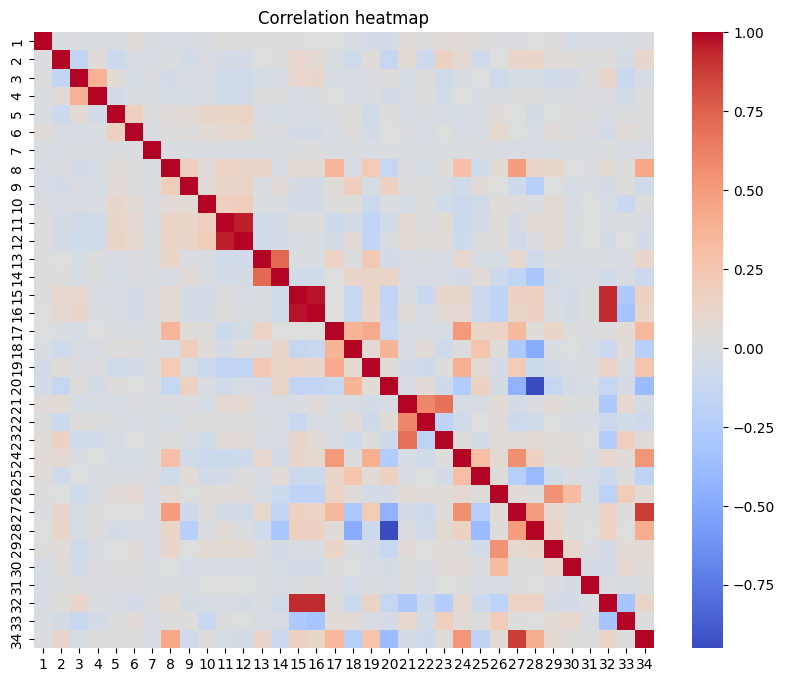

1                 166403
2                 166403
3                 146554
4                 146874
5                 147782
6                 141285
7                 143020
8                   9927
9                   9926
10                  5847
11                  9108
12                  9108
13                  9927
14                  9927
15                 11143
16                 11145
17                  8257
18                  8258
19                  9930
20                  9930
21                 11145
22                 11145
23                 11145
24                  9926
25                  9926
26                 10958
27                  9926
28                  9926
29                  9141
30                  2244
31                    41
32                 11145
33                 11141
34                 11137
timestamp(day)    175514
timestamp(hr)     175514
original          175514
dtype: int64
number of appropriate eigenvalues:  16


In [188]:
# 1) train dataset의 환자수
num_patients = len(patients)
print('number of patients: ', num_patients)

# 2) mean and median value of label timestamp(day)
print('mean value of label (day) w/o smote:', data['timestamp(day)'].mean(), 
    'median value of label (day): w/o smote', data['timestamp(day)'].median())

print('mean value of label (day) w smote:', before_norm_smote_data['timestamp(day)'].mean(), 
    'median value of label (day): w smote', before_norm_smote_data['timestamp(day)'].median())

# 3) dataset mean, std and heatmap of feature correlation matrix, and data sparsity
mean_std_values = pd.DataFrame(columns=['mean','std'])
mean_std_values['mean'] = before_norm_smote_data.iloc[:,:34].mean().values
mean_std_values['std'] = before_norm_smote_data.iloc[:,:34].std().values
print(mean_std_values)
correlation_matrix = before_norm_smote_data[before_norm_smote_data.columns[:34]].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()

print(naive_data)

# 4) answer is in report 
# 5) Calculating eigenvalues, finding appropriate number of dimension to reduce
dropped_smote_data = smote_data.drop(columns=['10','16','30','31'])
covariance = np.cov(dropped_smote_data.iloc[:,:30].T)
eigenvalue = np.linalg.eig(covariance)[0]
print("number of appropriate eigenvalues: " ,(eigenvalue>0.83).sum())

# Model Selection

I choose Lightgbm after testing 3 models xgboost, catboost and lightgbm.

The overall performance of lightgbm is better thatn the others.

In [189]:


train_data = dropped_smote_data.copy()
train_label = train_data.iloc[:,30]
train_label = train_label+5

d_train = lgb.Dataset(train_data.iloc[:,:30], label = train_label )


# Model Tuning



In [193]:

# parameter for model
params={}
params['learning_rate'] = 0.3
params['n_estimators'] = 400
params['lambda_l2'] = 0.1
params['boosting_type'] = 'gbdt'
# multiclass which uses softmax
params['objective'] = 'multiclass'
params['num_class'] = 6

# model train
clf = lgb.train(params, d_train, 100)

# There are no valid set, I didn't made it by myself. 
# This is f1-score of train set.
train_pred = clf.predict(train_data.iloc[:,:30]).argmax(axis=1) 
train_label[train_label <2] = 2
train_pred[train_pred<2] = 2
train_pred = pd.DataFrame(train_pred, columns=['prediction'])

print('train set\'s f1_score' , f1_score(train_label, train_pred, average='macro'))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7160
[LightGBM] [Info] Number of data points in the train set: 175514, number of used features: 30
[LightGBM] [Info] Start training from score -2.711383
[LightGBM] [Info] Start training from score -2.378150
[LightGBM] [Info] Start training from score -2.152674
[LightGBM] [Info] Start training from score -1.888764
[LightGBM] [Info] Start training from score -1.541912
[LightGBM] [Info] Start training from score -1.023236
train set's f1_score 0.963383839879208


Run this code Only once
------


In [97]:
test_data = pd.read_csv('test.csv')
test_data = test_data.dropna(subset=['original'])


gender = np.random.choice([0,1])
for i in test_data[test_data['1'].isnull()].iterrows():
    if i[1]['timestamp(hr)'] != 0:
        test_data['1'][i[0]] = gender
    else:
        test_data['1'][i[0]] = gender
        gender = np.random.choice([0,1])

# 나이가 NaN처리된 데이터는 나이의 평균값을 반올림하여 채움
test_data['2'].fillna(value= test_data['2'].mean().round(),inplace=True)

# 환자가 확진을 받는 시점 수 == 환자 수
patients= []
for idx, i in enumerate(test_data.iterrows()):
    if i[1]['timestamp(hr)'] == 0:
        patients.append(idx)

# 각 환자별로 빈값들을 Linear interpolate 밑 backfill
start =0
for  end in patients:
    test_data.iloc[start:end+1,:34] = test_data.iloc[start:end +1, :34].interpolate()
    start = end+1
start =0
for  end in patients:
    test_data.iloc[start:end+1,:34] = test_data.iloc[start:end +1, :34].interpolate(method='bfill')
    test_data.iloc[start:end+1,:34].fillna(test_data.iloc[start:end+1,:34].mean()+ random_weight*data.std(),inplace=True)
    start = end+1

test_data.iloc[:,0] = test_data.iloc[:,0].round()

scalar = StandardScaler()
features = test_data.columns[:34]
test_data[features] = scalar.fit_transform(test_data[features])
test_data = test_data.drop(columns=['10','16','30','31'])

y_label = test_data.iloc[:,30]
y_label += 5
y_label[y_label < 2] = 2

x_data = test_data.iloc[:,:30]

# Model Evaluation / Metrics

In [194]:
y_pred = clf.predict(x_data) 
y_pred = y_pred.argmax(axis=1)
y_pred[y_pred <2] = 2

y_pred = pd.DataFrame(y_pred, columns=['prediction'])

# y_pred = np.array(y_pred)
print('Accuracy: ',accuracy_score(y_label, y_pred))
print('F1-score(macro): ',f1_score(y_label, y_pred, average='macro'))
print('Precision: ',precision_score(y_label, y_pred,average='macro'))
print('Recall: ',recall_score(y_label, y_pred,average='macro'))

Accuracy:  0.33531977637156724
F1-score(macro):  0.2576544885866696
Precision:  0.2798399686421531
Recall:  0.27638637370294955
